In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt


import pyro
from svgsa.pathway_dispersion import select_highest_variance_gs
from sklearn.preprocessing import scale
from svgsa.VAE import VAE
from svgsa.Interface import fit_SVGSA
import torch
import pandas as pd
from tqdm import trange


/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.style.use('ggplot')

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: {}'.format(device))

Device: cuda:0


In [4]:
adata =  sc.datasets.pbmc68k_reduced()

In [5]:
adata

AnnData object with n_obs × n_vars = 700 × 765
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain'
    var: 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'bulk_labels_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [6]:
adata.obsm["raw"] = adata.raw.X.toarray().astype(np.float32)

In [7]:
filter_genes = 100
idx_to_filt = np.sum(adata.X > 0, axis = 0) > filter_genes
adata = adata[:,idx_to_filt]
adata.obsm["raw"] = adata.obsm["raw"][:,idx_to_filt]

In [8]:
adata.X

array([[-0.326, -0.728, -0.301, ...,  0.519, -0.636,  4.011],
       [ 1.171,  0.795, -1.2  , ...,  1.172,  2.63 , -0.49 ],
       [-0.326,  0.483, -1.2  , ...,  0.722,  0.663, -0.49 ],
       ...,
       [-0.326, -0.728, -1.2  , ...,  0.152, -0.636,  1.226],
       [-0.326, -0.728, -0.386, ..., -0.326, -0.636, -0.49 ],
       [-0.326,  0.148,  0.762, ...,  0.239, -0.636, -0.49 ]],
      dtype=float32)

In [9]:
### Loop the data lines
with open("data/cell_markers.txt", 'r') as temp_f:
    # get No of columns in each line
    col_count = [ len(l.split("\t")) for l in temp_f.readlines() ]

column_names = [i for i in range(0, max(col_count))]


gsts = pd.read_csv("data/cell_markers.txt",header=None, delimiter="\t", names=column_names,low_memory=False)

In [10]:
gsts

,0,1,2,3,4,5,6,7,8,9,...,1762,1763,1764,1765,1766,1767,1768,1769,1770,1771
0,BUSSLINGER_ESOPHAGEAL_QUIESCENT_BASAL_CELLS,http://www.gsea-msigdb.org/gsea/msigdb/cards/B...,CXCL14,DST,COL17A1,KRT15,SLC7A5,COL7A1,IL1R2,ZFP36L2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BUSSLINGER_ESOPHAGEAL_PROLIFERATING_BASAL_CELLS,http://www.gsea-msigdb.org/gsea/msigdb/cards/B...,KRT14,DST,ASS1,TOP2A,COL17A1,KRT15,SLC7A5,MKI67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BUSSLINGER_ESOPHAGEAL_EARLY_SUPRABASAL_CELLS,http://www.gsea-msigdb.org/gsea/msigdb/cards/B...,MT2A,STMN1,CDK1,KRT5,H2AZ1,RRM2,HMGB2,TUBA1B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BUSSLINGER_ESOPHAGEAL_LATE_SUPRABASAL_CELLS,http://www.gsea-msigdb.org/gsea/msigdb/cards/B...,SPRR3,CRNN,MAL,KRT4,SERPINB3,CSTB,SPRR1A,S100A9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BUSSLINGER_ESOPHAGEAL_DENDRITIC_CELLS,http://www.gsea-msigdb.org/gsea/msigdb/cards/B...,CD74,HLA-DRA,HLA-DRB1,HLA-DPA1,HLA-DQB2,HLA-DPB1,FCGBP,HLA-DQB1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,GAUTAM_EYE_IRIS_CILIARY_BODY_CILIARY_BODY_CELLS,http://www.gsea-msigdb.org/gsea/msigdb/cards/G...,MLF2,RND3,CHRDL1,KIAA1671,DARS1,PEX16,STK17A,SLC7A8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
696,GAUTAM_EYE_CORNEA_CYTOTOXIC_T_CELLS,http://www.gsea-msigdb.org/gsea/msigdb/cards/G...,SUGP1,LDB1,CEP72,COQ8B,CDK19,SLC12A9,DELE1,CCDC144A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
697,GAUTAM_EYE_IRIS_CILIARY_BODY_CRYAA_HIGH_CILIAR...,http://www.gsea-msigdb.org/gsea/msigdb/cards/G...,COX7A2L,RERE,KLF10,VTI1B,CSNK1E,JAM3,NLGN1,MAFF,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
698,GAUTAM_EYE_IRIS_CILIARY_BODY_COL9A1_HIGH_CILIA...,http://www.gsea-msigdb.org/gsea/msigdb/cards/G...,SYNGR2,SPART,PABPC1L,TENM1,TRIO,RANBP1,ZIC3,TRMT11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
gsts = gsts.transpose()
gsts.columns = gsts.iloc[0]
gsts = gsts[2:]

In [12]:
gsts_dict = gsts.apply(lambda x: [x.dropna()]).to_dict("list")


In [13]:
gsts_dict["FAN_EMBRYONIC_CTX_EX_1_EXCITATORY_NEURON"]

[2         ENC1
 3       PANTR1
 4    LINC01102
 5        MEIS2
 6          SLA
 7        CSRP2
 8        EIF1B
 Name: FAN_EMBRYONIC_CTX_EX_1_EXCITATORY_NEURON, dtype: object]

In [75]:
# pip install git+https://github.com/saezlab/progeny-py

import progeny

n_genes = 100

model = progeny.load_model(
        organism='Human',
        top=n_genes # Number of top significant target genes per pathway to use
    )

model

pathway,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
gene,,,,,,,,,,,,,,
ABCA12,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,9.597182
ABCA6,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,-3.271537,0.0,0.000000,0.0,0.0,0.000000
ABCA8,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,-1.709245,0.0,0.000000,0.0,0.0,0.000000
ABCC4,9.374285,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
ABCC5,0.000000,0.000000,-4.854988,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNFX1,0.000000,0.000000,0.000000,0.0,6.496398,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
ZNRF4,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1.033885,0.0,0.0,0.000000
ZSCAN2,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,-3.158743,0.000000,0.0,0.000000,0.0,0.0,0.000000


In [76]:
gsts = model
#gsts.columns = gsts.iloc[0]
#gsts = gsts[2:]
gsts

pathway,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
gene,,,,,,,,,,,,,,
ABCA12,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,9.597182
ABCA6,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,-3.271537,0.0,0.000000,0.0,0.0,0.000000
ABCA8,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,-1.709245,0.0,0.000000,0.0,0.0,0.000000
ABCC4,9.374285,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
ABCC5,0.000000,0.000000,-4.854988,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNFX1,0.000000,0.000000,0.000000,0.0,6.496398,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
ZNRF4,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1.033885,0.0,0.0,0.000000
ZSCAN2,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,-3.158743,0.000000,0.0,0.000000,0.0,0.0,0.000000


In [77]:
gsts_dict = gsts.apply(lambda x: gsts.index[np.abs(x) > 0.].tolist()).to_dict("list")
gsts_dict

{'Androgen': ['ABCC4',
  'ACPP',
  'ACSL3',
  'ADAM7',
  'ADPRM',
  'AFF3',
  'ARHGEF26',
  'AZGP1',
  'BMPR1B',
  'C1orf116',
  'CAMKK2',
  'CBLL1',
  'CDK8',
  'CENPN',
  'CHRNA2',
  'CLDN8',
  'CROT',
  'CSGALNACT1',
  'CTBP1',
  'CTNNA2',
  'DHCR24',
  'DNASE2B',
  'DNM1L',
  'EAF2',
  'ECI2',
  'ELK4',
  'ELL2',
  'ENDOD1',
  'F5',
  'FAM105A',
  'FRK',
  'FUT8',
  'FZD5',
  'GCG',
  'GNMT',
  'GPR63',
  'GRHL2',
  'GRIK1',
  'HOXC13',
  'IGF1',
  'IGF1R',
  'IQGAP2',
  'KCNMA1',
  'KCNN2',
  'KLF15',
  'KLK2',
  'KLK3',
  'LIFR',
  'LPAR3',
  'LRIG1',
  'LRRC31',
  'LRRFIP2',
  'MAF',
  'MAK',
  'MALT1',
  'MANEA',
  'MBOAT2',
  'MCCC2',
  'MPC2',
  'MPHOSPH9',
  'MRPS18A',
  'MTMR9',
  'MYBPC1',
  'MYNN',
  'NCAPD3',
  'NKX3-1',
  'NPPC',
  'NSMAF',
  'OPRK1',
  'PAK1IP1',
  'PDE9A',
  'PEX10',
  'PGC',
  'PHF8',
  'PMEPA1',
  'PPP2CB',
  'PSMD8',
  'RAB3B',
  'SCAP',
  'SEC14L2',
  'SELENOP',
  'SGK1',
  'SI',
  'SLC15A2',
  'SLC38A4',
  'SLITRK3',
  'SNAI2',
  'SORD',
  'SPDEF

In [105]:
pyro.enable_validation()
#torch.autograd.set_detect_anomaly(True)

adata_new, model, loss = fit_SVGSA(adata, gsts_dict, z_dim_gs=2, z_dim_uns=5,
                                   
                                   num_iafs =0, batch_size=1024, epochs=1000, 
                                   
                                   N_GS=12, normalize = False,lr = 0.001, CUDA = True, iaf_dim=50, fixed = False)   #batch_size=1024

Epoch loss 569973.162318: 100%|██████████| 1000/1000 [00:25<00:00, 39.12it/s]


In [ ]:
plt.figure(figsize=(5, 2))
plt.plot(loss)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [ ]:
sc.pl.umap(adata, color = "bulk_labels")

In [ ]:
print( adata_new.obsm["X_svgsa_gs"].shape )
adata_new.obsm["X_svgsa_gs"]

In [ ]:
import seaborn as sns

sns.scatterplot(x = adata_new.obsm["X_svgsa_gs"][:,0], y = adata_new.obsm["X_svgsa_gs"][:,1], hue = adata_new.obs.bulk_labels, palette="tab10")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

In [ ]:
sc.pp.neighbors(adata_new, use_rep="X_svgsa_gs")
sc.tl.umap(adata_new, n_components=2)

In [ ]:
sc.pl.umap(adata_new, color = "bulk_labels")

In [ ]:
print( adata_new.obsm["X_svgsa_uns"].shape )
adata_new.obsm["X_svgsa_uns"]

In [ ]:
sns.scatterplot(x = adata_new.obsm["X_svgsa_uns"][:,0], y = adata_new.obsm["X_svgsa_uns"][:,1], hue = adata_new.obs.bulk_labels, palette="tab10")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

In [ ]:
sc.pp.neighbors(adata_new, use_rep="X_svgsa_uns")
sc.tl.umap(adata_new, n_components=2)

In [ ]:
sc.pl.umap(adata_new, color = "bulk_labels")

In [101]:
sc.pp.neighbors(adata_new, use_rep="X_svgsa")
sc.tl.umap(adata_new, n_components=4)

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


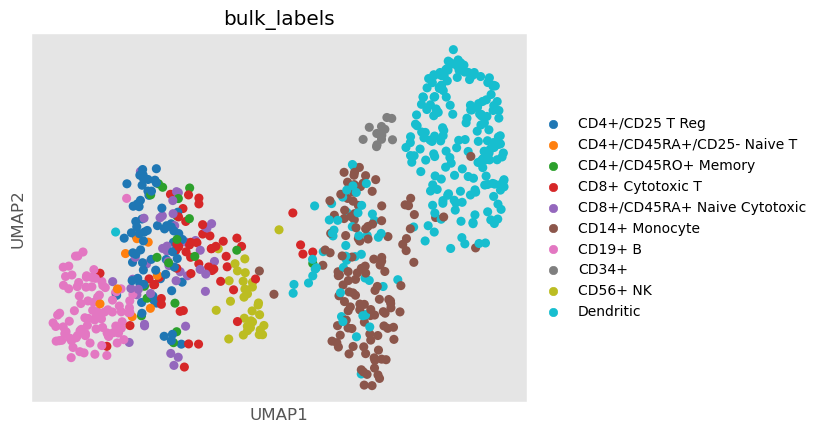

In [102]:
sc.pl.umap(adata_new, color = "bulk_labels")

In [59]:
print(adata_new.obsm["X_reconstructed"])

[[0.26557677 0.68762906 1.50180059 ... 1.48783349 0.52451435 0.36135741]
 [0.26558142 0.68764594 1.50185111 ... 1.48789315 0.52452256 0.36136511]
 [0.26556522 0.68767678 1.5017478  ... 1.48786195 0.52456661 0.36134231]
 ...
 [0.26557592 0.68764095 1.50184396 ... 1.48787224 0.52453413 0.36136312]
 [0.26562275 0.68765481 1.50186198 ... 1.48790219 0.52452464 0.36135124]
 [0.26560244 0.68765837 1.5018966  ... 1.48792802 0.52451577 0.36136629]]


In [60]:
torch.tensor(adata.X)

tensor([[-0.3260, -0.7280, -0.3010,  ...,  0.5190, -0.6360,  4.0110],
        [ 1.1710,  0.7950, -1.2000,  ...,  1.1720,  2.6300, -0.4900],
        [-0.3260,  0.4830, -1.2000,  ...,  0.7220,  0.6630, -0.4900],
        ...,
        [-0.3260, -0.7280, -1.2000,  ...,  0.1520, -0.6360,  1.2260],
        [-0.3260, -0.7280, -0.3860,  ..., -0.3260, -0.6360, -0.4900],
        [-0.3260,  0.1480,  0.7620,  ...,  0.2390, -0.6360, -0.4900]],
       dtype=torch.float32)

# Standard analysis

In [28]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [29]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [30]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [31]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)


c:\Users\Lorzo\miniconda3\envs\thesis_env\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\Lorzo\miniconda3\envs\thesis_env\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [32]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])


In [33]:
sc.pp.scale(adata, max_value=10)


In [34]:
sc.tl.pca(adata, svd_solver='arpack')


In [35]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)


In [36]:
sc.tl.umap(adata)


In [37]:
sc.tl.leiden(adata)


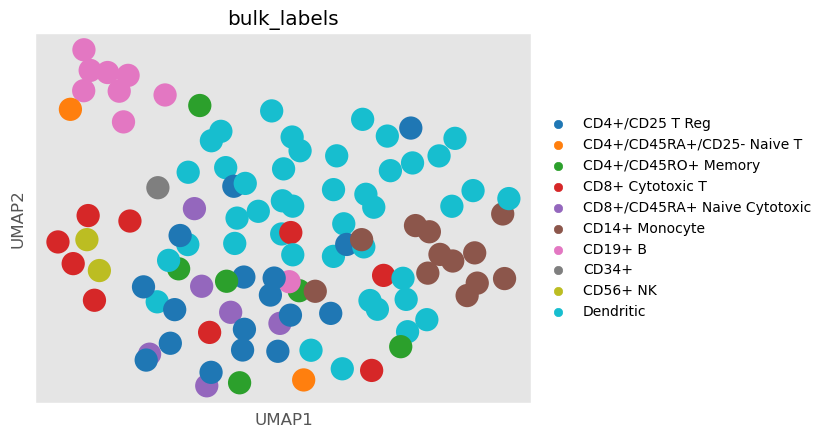

In [38]:
sc.pl.umap(adata,  color = "bulk_labels")